# Challenge Overview
In this challenge, the `requests` dataset contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request.

The data contains about 480k samples (with data related to requests, groups and individuals). The number of nights is only known for a subset of requests (the learning base). Your objective is to predict the number of nights for the requests of the test dataset. The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `train_requests`, the predictions should be made for requests listed in the `test_requests` dataset.

The target represents a categorized number of nights that the person or group will stay in an emergency structure:
```
    0: the person or group won’t be granted a solution or has refused it
    1: 1 or 2 nights
    2: between 3 nights (included) and 1 month
    3: more than 1 month
```

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

Good luck!



In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

np.random.seed(1337)

## 1) Load data

In [2]:
# Load training set
# set request_id as index
train = pd.read_csv(filepath_or_buffer='data/train_requests.csv',
                    sep=',', low_memory=False, error_bad_lines=False,
                    index_col=0)

# Load testing set
# set request_id as index
# note: testing set does not have the column "granted_number_of_nights"
test = pd.read_csv(filepath_or_buffer='data/test_requests.csv',
                   sep=',', low_memory=False, error_bad_lines=False,
                   index_col=0)

# Rename "granted_number_of_nights" to "target"
train = train.rename(columns={'granted_number_of_nights': 'target'})

# Create target column in testing set before (train + test) concatenation
test['target'] = np.nan

# Create train/test variable before (train + test) concatenation
train['training'] = 1
test['training'] = 0

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


## 2) Quick exploratory analysis of the training set

In [3]:
# chech unique labels in target
train["target"].unique()

array([1, 2, 0, 3])

In [4]:
# normalized counts of the target labels
train['target'].value_counts(normalize=True)

0    0.489499
1    0.343257
2    0.156463
3    0.010781
Name: target, dtype: float64

In [5]:
# absolute counts of the labels
train['target'].value_counts()

0    145743
1    102201
2     46585
3      3210
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

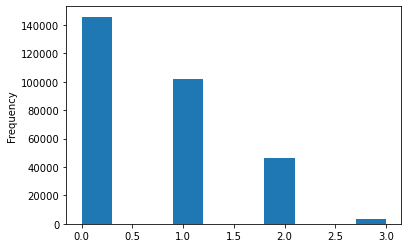

In [6]:
train['target'].plot.hist()

In [7]:
# number of unique values in each variables
train.nunique()

animal_presence                       2
answer_creation_date             277562
child_situation                       8
child_to_come                         2
district                            102
target                                4
group_composition_id                 13
group_composition_label              12
group_creation_date               61766
group_id                          63140
group_main_requester_id           60950
group_type                            2
housing_situation_id                 22
housing_situation_label              21
long_term_housing_request             2
number_of_underage                   13
request_backoffice_creator_id      1088
request_creation_date            277725
requester_type                        3
social_situation_id               63112
town                               1168
victim_of_violence                    2
victim_of_violence_type               6
training                              1
dtype: int64

In [8]:
# training set size
print(train.shape)

(297739, 24)


In [9]:
# testing set size
print(test.shape)

(74189, 24)


In [10]:
# check object and boolean variables
train.describe(include=['object', 'bool'])

,animal_presence,answer_creation_date,child_to_come,group_composition_label,group_creation_date,group_id,group_main_requester_id,group_type,housing_situation_label,long_term_housing_request,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
count,297739,297739,115453,297738,297738,297739,297739,297738,276802,90926,297739,297739,297739,297739,98051,297738,4984
unique,2,277562,2,12,61766,63140,60950,2,21,2,1088,277725,3,63112,1168,2,6
top,f,2019-01-01 07:00:00,f,man alone,2017-07-17 00:00:00.000,26ea416385179d96f07aaca883dfeb19,19f587b018a6410be66712171d654a11,individual,street,f,7c1f3fa2eb9a8779c8e83441317acb3d,2019-01-01 07:00:00,user,2b5e0d51245ed6c5d4b57edaef2b8392,Saint-Étienne,f,woman
freq,296908,92,107529,163208,151,81,81,213882,127315,75630,3567,92,293409,266,5734,292382,2700


In [11]:
# check integers and float variables
train.describe(include=['int', 'float'])

,child_situation,district,target,group_composition_id,housing_situation_id,number_of_underage,training
count,297739.000000,297739.000000,297739.000000,297739.000000,297739.000000,297739.000000,297739.0
mean,-0.321184,7045.224250,0.688526,27.908198,121.964304,-0.575531,1.0
std,4.089209,46442.365582,0.769463,28.870664,83.231413,0.859217,0.0
min,-1.000000,1.000000,0.000000,-1.000000,10.000000,-1.000000,1.0
25%,-1.000000,35.000000,0.000000,10.000000,10.000000,-1.000000,1.0
50%,-1.000000,61.000000,1.000000,10.000000,170.000000,-1.000000,1.0
75%,-1.000000,81.000000,1.000000,40.000000,200.000000,0.000000,1.0
max,70.000000,315842.000000,3.000000,120.000000,220.000000,14.000000,1.0


## 3) Feature engineering
A single LightGBM model with strong feature engineering on categorical variables and dates:

**The 2 keys to the challenge were as follows:**

Key 1: correctly optimize the loss function. The loss function was a bit tricky in this challenge:

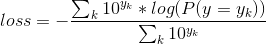

In [12]:
from IPython.display import Image
Image(filename='./data/loss_function.png') 

In English terms, it means that errors on category 3 are much more penalizing (10^3) than errors on category 0. Ignoring this loss function and optimizing the log-loss was therefore doomed to failure, no matter how good your feature engineering was. The simplest way to optimize the loss function is to optimize the log loss by weighting your samples. LightGBM allows you to assign a weight to each of your sample in the fit function:

```
lgb.fit(X, y, sample_weight=10**y)
```

Another way to optimize this loss function was to code a custom loss function and to feed it to LightGBM but it would have taken longer for the exact same result.

Key 2: manage categorical variables well. Most of the predictive signal was present in the categorical variables, especially those with many modalities (group_id, group_main_requester_id, housing_situation_id, etc.). I used 3 tricks to create useful variables derived from these categorical variables:
- Label Encoding
- Value Count
- Target Encoding

In [13]:
# concatenation train+test
df = pd.concat((train[train.columns], test[train.columns]), axis=0)

In [14]:
df.shape

(371928, 24)

In [15]:
# to see the number of null data in each variables
desc = df.describe()  # Returns a DataFrame with stats in the row index
combo = pd.concat([df.isna().sum(),desc.T],axis=1).set_axis(['Nulls']+list(desc.index),axis=1,inplace=False)

combo = combo[["Nulls","count"]]
combo = combo[combo["Nulls"] > 0]
combo

,Nulls,count
child_to_come,227871,NaN
target,74189,297739.0
group_composition_label,1,NaN
group_creation_date,1,NaN
group_type,1,NaN
housing_situation_label,26181,NaN
long_term_housing_request,258347,NaN
town,249517,NaN
victim_of_violence,1,NaN
victim_of_violence_type,365700,NaN


In [16]:
# categorical features: skip all variables with _creation_date and the int64 variables, except for district
categorical_features = ['animal_presence',
                        'child_to_come', # 227871 null
                        'group_composition_label', # 1 null
                        'group_id',
                        'group_main_requester_id',
                        'group_type', # 1 null
                        'housing_situation_label', # 26181 null
                        'long_term_housing_request', # 258347 null
                        'request_backoffice_creator_id',
                        'requester_type',
                        'social_situation_id',
                        'town', # 249517 null
                        'victim_of_violence', # 1 null
                        'victim_of_violence_type', # 365700 null
                        'district']

### 3a) Label encoding
Encode each category to a single number, it seems counter-intuitive but tree-based models (like LightGBM) manage to pull predictive signal from these kind of variables. 
```
Eg. 
- nan/false/true -> -1/0/2
- 2 categories -> 0, 1
- 3 categories -> 0, 1, 2
- 6 categories -> 0, 1, 2, 3, 5, 6
```

In [17]:
# label encoding
# note: fit_transform will throw error if the column contains nan
for var in categorical_features:
    encoder = LabelEncoder()
    
    # set column to string type
    df[var] = df[var].astype(str)
    
    df['le_{}'.format(var)] = encoder.fit_transform(df[var])    
    df.loc[df[var] == 'nan', 'le_{}'.format(var)] = -1

### 3b) Label encoding
Another way to extract information from a categorical variables, just count the number of occurance for each unique category value (inclusive of counting number of nan values).

```
Eg. 
370913 True/1015 False -> 370913/1015
9841 True/134216 False/227871 NaN -> 9841/134216/227871
```

In [21]:
# value counts
for var in categorical_features:
    mapping_vc = df[var].value_counts()
    df['vc_{}'.format(var)] = df[var].map(mapping_vc)

### 3c) Date features
Extract day of the datetime, week of the datetime, month, year, hour (0-23) and weekday (0-6)

In [23]:
# date features
def create_date_features(df, column):
    df[column] = pd.to_datetime(df[column])
    df['day_{}'.format(column)] = df[column].dt.day
    df['week_{}'.format(column)] = df[column].dt.isocalendar().week
    df['month_{}'.format(column)] = df[column].dt.month
    df['year_{}'.format(column)] = df[column].dt.year
    df['hour_{}'.format(column)] = df[column].dt.hour
    df['weekday_{}'.format(column)] = df[column].dt.weekday
    #df['numeric_{}'.format(column)] = df[column].astype(np.int64) * 1e-9
    return df

# note: group_creation_date = 1 null data, will throw error to .astype(np.int64)
for date_col in ['answer_creation_date',
                 'group_creation_date',
                 'request_creation_date']:
    df[date_col] = create_date_features(df, date_col)
    df.drop(date_col, axis=1, inplace=True)


### 3d) Target encoding
The process of computing the mean of the target variable for each modality of the categorical variable.

In [25]:
# target encoding
def target_encoding(df, grp_col, target_col, n_folds=10):
    df['fold'] = np.random.randint(n_folds, size=len(df))
    df_te = pd.DataFrame()
    for fold in df['fold'].unique():
        df_fold = df[df['fold'] != fold].groupby(grp_col)[target_col].agg(['mean', 'count'])
        df_fold['fold'] = fold
        df_te = df_te.append(df_fold.reset_index())
    df_te.rename(columns={'mean': 'te_mean_{}'.format('_'.join(grp_col)),
                          'count': 'te_count_{}'.format('_'.join(grp_col))},
                 inplace=True)
    df = pd.merge(df, df_te, how='left')
    df.drop('fold', axis=1, inplace=True)
    return df

te_grp_cols = [['group_id'],
               ['group_main_requester_id'],
               ['request_backoffice_creator_id'],
               ['social_situation_id'],
               ['housing_situation_id'],
               ['district'],
               ['town'],
               ['social_situation_id', 'group_main_requester_id'],
               ['social_situation_id', 'group_id'],
               ['social_situation_id', 'request_backoffice_creator_id'],
               ['group_main_requester_id', 'group_id'],
               ['group_main_requester_id', 'request_backoffice_creator_id'],
               ['group_id', 'request_backoffice_creator_id'],
               ['social_situation_id', 'housing_situation_id'],
               ['group_main_requester_id', 'housing_situation_id'],
               ['group_id', 'housing_situation_id'],
               ['request_backoffice_creator_id', 'housing_situation_id']]

for grp_col in te_grp_cols:
    df = target_encoding(df=df, grp_col=grp_col, target_col='target', n_folds=10)

## 4) Data Modeling
### 4a) Create X & X_test

In [16]:
dtypes = df.dtypes.map(str)
numerical_features = list(dtypes[dtypes.isin(['int64','float64'])].index)
X_full = df[numerical_features].copy()

X = X_full[X_full['training'] == 1].copy()
X_test = X_full[X_full['training'] == 0].copy()
y = X_full[X_full['training'] == 1]['target']

X.drop(['target', 'training'], axis=1, inplace=True)
X_test.drop(['target', 'training'], axis=1, inplace=True)

### 4b) Fit the model

In [17]:
lgb = LGBMClassifier(nthread=8,
                     objective='logloss',
                     n_estimators=400,
                     num_leaves=45,
                     learning_rate=0.03,
                     subsample=1.0,
                     subsample_freq=1,
                     colsample_bytree=0.3,
                     min_child_samples=10)

lgb.fit(X, y, sample_weight=10**y)

[LightGBM] [Warning] num_threads is set with nthread=8, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.3, learning_rate=0.03, min_child_samples=10,
               n_estimators=400, nthread=8, num_leaves=45, objective='logloss',
               subsample_freq=1)

## 5) Predict and Submit

In [18]:
preds = lgb.predict_proba(X_test)

df_pred = pd.concat([pd.DataFrame(test.index),
                     pd.DataFrame(preds)],
                    axis=1)

In [19]:
df_pred.to_csv('data/submit.csv', index=False)